In [19]:
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
np.random.seed(1001)

In this code we will give yet another example for the usage of eigenvalue optimization.

Assume we have an ant living in the plane that wants to find out more about the environment it is living in. We, as observers can see where the ant is located at, that is in cartesian coordinates

In [20]:
ants_position = np.array([3, 4])

In this plane there is now also a solid object, a circle, which we as observers can describe as

In [21]:
circle_radius = 2
circle_origin = np.array([0, 0])

Lets have an overview of the situation!

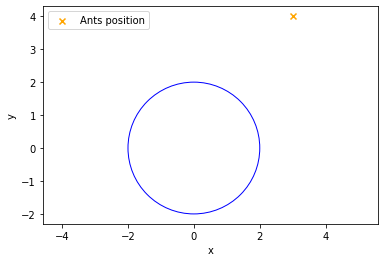

In [22]:
ax = plt.gca()
ax.add_patch(plt.Circle(circle_origin, circle_radius, color='b', fill=False))
ax.scatter(ants_position[0], ants_position[1], marker='x', color='orange', label='Ants position')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.axis('equal')
plt.show()

The ant has now also measurement device with which it can probe its environment. This sensor
gives back as information an angle together with a distance measurment from whatever direction the ant
is pointing the device at.

For this, lets now create a helper function that, given a directional unit vector v outputs the distance (in case there is an intersect) to the circle (defined by the above parameters), seen from the ants position defined above. In case there is no intersect the return value is infinity.

In [23]:
def intersect(v):
    a = np.sum(v**2, axis=-1)
    b = 2 * np.sum(v * (ants_position - circle_origin), axis=-1)
    c = np.sum((ants_position - circle_origin)**2, axis=-1) - circle_radius**2
    
    d = b**2 - 4 * a * c
    
    with np.errstate(all='ignore'):
        d = np.where(d > 0, np.sqrt(d), np.inf)
        
        t1 = (-b + d) / (2 * a)
        t2 = (-b - d) / (2 * a)
        
        t1 = np.where(t1 >= 0, t1, np.inf)
        t2 = np.where(t2 >= 0, t2, np.inf)
        
        t = np.where(t1 < t2, t1, t2)
        
    return t

The ant now takes some measurement around its position. It points the sensor along the angles

In [24]:
angles = np.arange(360) * np.pi / 180

which correspond to the following directional vectors

In [25]:
vectors = np.concatenate([np.cos(angles).reshape(-1, 1), np.sin(angles).reshape(-1, 1)], axis=1)

The measurements along theese angles now give back the following distance values

In [26]:
distances = intersect(vectors)

From which we only keep the finite ones (no intersections give back an infinite distance)

In [27]:
arg = np.isfinite(distances)
angles = angles[arg]
distances = distances[arg]
vectors = vectors[arg, :]

From these values we can now create some positional information about the object which the ant sees, in Cartesian coordinates, with the center at the observer we get

In [28]:
xy = vectors * distances.reshape(-1, 1)

We can also add some noise to it

In [29]:
noise_level = 1e-2

xy = xy + np.random.randn(xy.shape[0], xy.shape[1]) * noise_level

Lets check out those measurements.

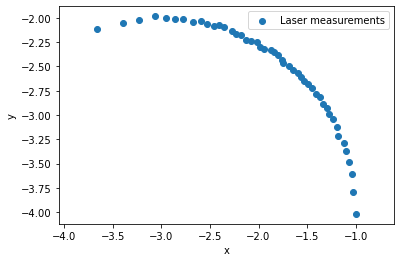

In [30]:
ax = plt.gca()
ax.scatter(xy[:, 0], xy[:, 1], label='Laser measurements')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.axis('equal')
ax.legend()
plt.show()

Seen from our global observer position, together with the actaul circle and the ants position we have

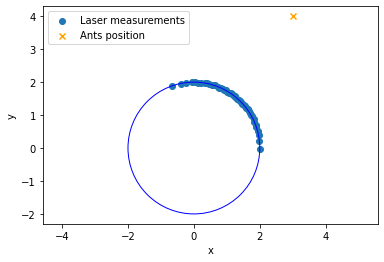

In [31]:
ax = plt.gca()
ax.scatter(xy[:, 0] + ants_position[0], xy[:, 1] + ants_position[1], label='Laser measurements')
ax.add_patch(plt.Circle(circle_origin, circle_radius, color='b', fill=False))
ax.scatter(ants_position[0], ants_position[1], marker='x', color='orange', label='Ants position')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.axis('equal')
ax.legend()
plt.show()

Now lets say the ant knows that the object it sees is a circle, however neither of which raidus nor its distance
to the center. It would like to find out more about its position in relation to the circles center. 
There would exist a rather simple way for getting the circles properties directly from the measurments, 
however our ant likes challenges. Thats why it decides to look at its data in polar coordinates.

In [32]:
# The function converting the values is
def to_polar(xy, der=False):
    r = np.linalg.norm(xy, axis=1)
    a = np.arctan2(xy[:, 1], xy[:, 0])
    
    ar = np.concatenate([a.reshape(-1, 1), r.reshape(-1, 1)], axis=1)
    
    if der:
        d_a_d_x = -xy[:, 1] / np.sum(xy**2, axis=1)
        d_a_d_y = xy[:, 0] / np.sum(xy**2, axis=1)
        
        d_r_d_x = xy[:, 0] / r
        d_r_d_y = xy[:, 1] / r
        
        J_ar = np.zeros((2,) + ar.shape)
        J_ar[0, :, 0] = d_a_d_x
        J_ar[1, :, 0] = d_a_d_y
        J_ar[0, :, 1] = d_r_d_x
        J_ar[1, :, 1] = d_r_d_y
        
        return ar, J_ar
    else:
        return ar
    
# The ants data in polar coordinates is then
ar = to_polar(xy)

Lets have a look at it


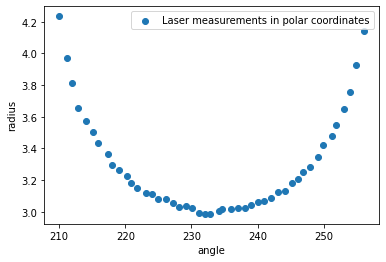

In [33]:
ax = plt.gca()
ax.scatter(np.mod(ar[:, 0], 2 * np.pi) * 180 / np.pi, ar[:, 1], label='Laser measurements in polar coordinates')
ax.set_xlabel('angle')
ax.set_ylabel('radius')
ax.legend()
plt.show()

Since our ant is a smart one, it knows that if it would be standing at the center of the circle, its data in polar coordinates would look like a flat line. Indeed, we as observers can confirm that

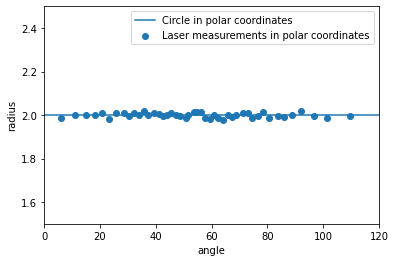

In [34]:
ar = to_polar(xy + ants_position)

ax = plt.gca()
plt.ylim(1.5, 2.5)
plt.xlim(0, 120)
ax.scatter(np.mod(ar[:, 0], 2 * np.pi) * 180 / np.pi, ar[:, 1], label='Laser measurements in polar coordinates')
ax.plot((0, 360), (circle_radius, circle_radius), label='Circle in polar coordinates')
ax.set_xlabel('angle')
ax.set_ylabel('radius')
ax.legend()
plt.show()

The ant now creates iis loss function, taking as input "v" a guess for its position in relation to the circles center, given in cartesian coordinates

In [35]:
def loss(v):
    ar = to_polar(xy + v).reshape(-1, 2, 1)
    
    mu = np.mean(ar, axis=0)
    S = np.mean(ar @ np.swapaxes(ar, -1, -2), axis=0) - mu @ np.swapaxes(mu, -1, -2)

    w, _ = np.linalg.eigh(S)
    w = w[0].reshape(-1)
    
    return w

def d_loss(v):
    ar, d_ar = to_polar(xy + v, der=True)
    d_ar = d_ar.reshape(2, -1, 2, 1)
    ar = ar.reshape(-1, 2, 1)
    
    mu = np.mean(ar, axis=0)
    d_mu = np.mean(d_ar, axis=1)
    
    S = np.mean(ar @ np.swapaxes(ar, -1, -2), axis=0) - mu @ np.swapaxes(mu, -1, -2)
    d_S = np.mean(d_ar @ np.swapaxes(ar, -1, -2), axis=1) + \
          np.mean(ar @ np.swapaxes(d_ar, -1, -2), axis=1) - \
          d_mu @ np.swapaxes(mu, -1, -2) - \
          mu @ np.swapaxes(d_mu, -1, -2)
          
    w, v = np.linalg.eigh(S)
    w, v = w[0], v[:, [0]]
    d_w = (np.swapaxes(v, -1, -2) @ d_S @ v).reshape(1, -1)
    
    return d_w

And the ant tries to optimize it, with starting value a wild guess


In [36]:
v0 = np.array([0, 0])
res = least_squares(loss, v0, d_loss, method='trf', 
                    gtol=None, xtol=None, max_nfev=None)

Something must have gone wrong. The guess for the spectators position is way off


Estimated position: [-14.18742199   1.98324112]


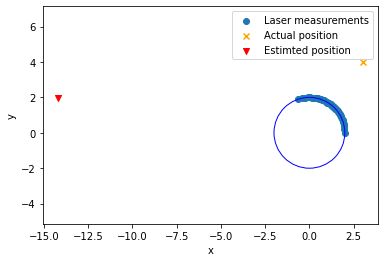

In [37]:
print(f"Estimated position: {res.x}")

ax = plt.gca()
ax.scatter(xy[:, 0] + ants_position[0], xy[:, 1] + ants_position[1], label='Laser measurements')
ax.add_patch(plt.Circle(circle_origin, circle_radius, color='b', fill=False))
ax.scatter(ants_position[0], ants_position[1], marker='x', color='orange', label='Actual position')
ax.scatter(res.x[0], res.x[1], marker='v', color='red', label='Estimted position')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.axis('equal')
ax.legend()
plt.show()

The middle values appear flatter, but thats not the way we expected it to work


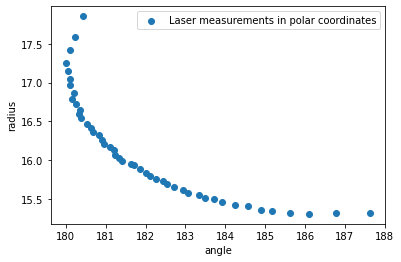

In [38]:
ar = to_polar(xy + res.x)

ax = plt.gca()
ax.scatter(np.mod(ar[:, 0], 2 * np.pi) * 180 / np.pi, ar[:, 1], label='Laser measurements in polar coordinates')
ax.set_xlabel('angle')
ax.set_ylabel('radius')
ax.legend()
plt.show()

Indeed, if we plot the loss functions across different starting values v, we see that there is quite some slope inbetween the minima and our initial guess. (Black is the actual optima, green our initial guess and orange the found solution)

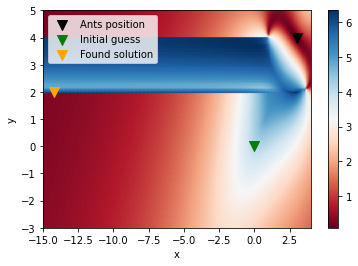

In [39]:
steps = 200
x_range = (-15, 4)
y_range = (-3, 5)

x_values, y_values, f_values = [], [], []

for x_value in np.linspace(x_range[0], x_range[1], steps):
    for y_value in np.linspace(y_range[0], y_range[1], steps):
        v = np.array([x_value, y_value])

        x_values.append(x_value)
        y_values.append(y_value)
        f_values.append(loss(v))

x_values = np.array(x_values).reshape(steps, steps)
y_values = np.array(y_values).reshape(steps, steps)
f_values = np.array(f_values).reshape(steps, steps)

# some rescaling in order to see the valley better
f_values = np.log(f_values * 1e3 + 1)

ax = plt.gca()

plot = plt.pcolormesh(x_values, y_values, f_values, cmap='RdBu', shading='gouraud')
ax.scatter(ants_position[0], ants_position[1], marker='v', s=100, color='k', label='Ants position')
ax.scatter(v0[0], v0[1], marker='v', s=100, color='g', label='Initial guess')
ax.scatter(res.x[0], res.x[1], marker='v', s=100, color='orange', label='Found solution')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.colorbar(plot)

plt.show()

This is likely due to the incontinuity regarding the smallest eigenvalues. If we look at the map close to the actual optima, we see however that in this region the problem is well defined.

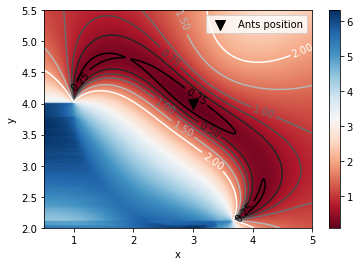

In [40]:
steps = 200
x_range = (0.5, 5)
y_range = (2, 5.5)

x_values, y_values, f_values = [], [], []

for x_value in np.linspace(x_range[0], x_range[1], steps):
    for y_value in np.linspace(y_range[0], y_range[1], steps):
        v = np.array([x_value, y_value])

        x_values.append(x_value)
        y_values.append(y_value)
        f_values.append(loss(v))

x_values = np.array(x_values).reshape(steps, steps)
y_values = np.array(y_values).reshape(steps, steps)
f_values = np.array(f_values).reshape(steps, steps)

# some rescaling in order to see the valley better
f_values = np.log(f_values * 1e3 + 1)

ax = plt.gca()

plot = plt.pcolormesh(x_values, y_values, f_values, cmap='RdBu', shading='gouraud')
cset = plt.contour(x_values, y_values, f_values, cmap='gray',
                  levels=np.array([0.25, 0.5, 0.75, 1, 1.5, 2])) 
ax.clabel(cset, inline=True)
ax.scatter(ants_position[0], ants_position[1], marker='v', s=100, color='k', label='Ants position')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.colorbar(plot)

plt.show()

Lets give the ant a small hint to start the optimization closer at the actual solution.


In [41]:
v0 = np.array([2.5, 4.5])
res = least_squares(loss, v0, d_loss, method='trf',
                    gtol=None, xtol=None, max_nfev=None)

This looks better. Without knowing any properties about the circle beforehand (and our small help), the ant managed to estimate its position from the cirecles center fairly well.


Estimated position: [2.94418955 4.03211298]


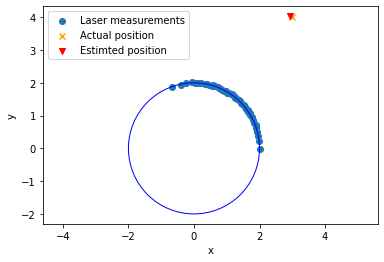

In [42]:
print(f"Estimated position: {res.x}")

ax = plt.gca()
ax.scatter(xy[:, 0] + ants_position[0], xy[:, 1] + ants_position[1], label='Laser measurements')
ax.add_patch(plt.Circle(circle_origin, circle_radius, color='b', fill=False))
ax.scatter(ants_position[0], ants_position[1], marker='x', color='orange', label='Actual position')
ax.scatter(res.x[0], res.x[1], marker='v', color='red', label='Estimted position')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.axis('equal')
ax.legend()
plt.show()

Now in this particular case we might have directly gone ahead and minimzed the covariance
along the polar coordinates 'y-axis', that is the distance values. Since we already know 
the resulting points should form a flat line we therefore could have simply taken S[1, 1]
as the residual. This would have maybe led to a better convergence behaviour. However our goal here was to showcase the more general eigenvalue case, thats why we 
went ahead with this approach.